In [1]:
# importing two required module 
import numpy as np
import matplotlib.pyplot as plt
import toolz
import optax
import jax.numpy as jnp
import jax
from flax import linen as nn


In [2]:
def get_point_on_a_line(vertex_1,vertex_2,weight):
    """ 
    so we want to get a section between vertex_1,vertex_2 
    we first need to calcualte a slope of the line 
    https://www.w3schools.com/datascience/ds_linear_slope.asp

    then we need to move up on a line with calculated slope as in 
    https://www.geeksforgeeks.org/find-points-at-a-given-distance-on-a-line-of-given-slope/
    """
    #we get a slope
    slope = (vertex_2[1]-vertex_1[0])/(vertex_2[0]-vertex_1[0])
    #now we need a distance travelled on a line
    vertex_diff=vertex_1-vertex_2
    l= np.sqrt(np.dot(vertex_diff,vertex_diff ))*weight

    dx = (l / np.sqrt(1 + (slope * slope)))
    dy = slope * dx
    
    return np.array([vertex_1[0]+dx, vertex_1[1]+dy])



def lineLineIntersection(A, B, C, D):
    """ 
    based on https://www.geeksforgeeks.org/program-for-point-of-intersection-of-two-lines/
    """
    # Line AB represented as a1x + b1y = c1
    a1 = B[1] - A[1]
    b1 = A[0] - B[0]
    c1 = a1*(A[0]) + b1*(A[1])
 
    # Line CD represented as a2x + b2y = c2
    a2 = D[1] - C[1]
    b2 = C[0] - D[0]
    c2 = a2*(C[0]) + b2*(C[1])
    

    determinant = (a1*b2 - a2*b1)+0.000000000001
    
    # if (determinant == 0):
    #     # The lines are parallel. This is simplified
    #     # by returning a pair of FLT_MAX
    #     return Point(10**9, 10**9)
    # else:
    x = (b2*c1 - b1*c2)/determinant
    y = (a1*c2 - a2*c1)/determinant
    return jnp.array([x, y])

def orthoProjection(vertex_a,vertex_b,vertex_c):
    """ 
    projection of a point on a line 
    adapted from https://stackoverflow.com/questions/55230528/find-point-where-altitude-meets-base-python
    """
    # abx = bx - ax
    abx = vertex_b[0] - vertex_a[0]
    # aby = by - ay
    aby = vertex_b[1] - vertex_a[1]
    # acx = cx - ax
    acx = vertex_c[0] - vertex_a[0]
    # acy = cy - ay
    acy = vertex_c[1] - vertex_a[1]
    t = (abx * acx + aby * acy) / ((abx * abx + aby * aby)+0.000000001)
    # px = ax + t * abx
    px = vertex_a[0] + t * abx
    # py = ay + t * aby
    py = vertex_a[1] + t * aby
    return jnp.array([px, py])


def get_point_on_a_line_b(vertex_0,vertex_1,weight):
    diff_x=vertex_1[0]-vertex_0[0]
    diff_y=vertex_1[1]-vertex_0[1]
    # weight=weight/2+1.5
    # weight=(weight*2)

    # C=jnp.array([vertex_0[0]+(diff_x*weight), vertex_0[1]])
    # D=jnp.array([vertex_0[0],vertex_0[1]+(diff_y*weight)])

    # alpha=np.pi/4
    # beta=-np.pi/4
    # a= vertex_0
    # #just multiplied by rotation matrix, we divide by square root of 2 in order to keep the weights in domain 1 to two
    # C= np.array([  a[0]*np.cos(alpha) + a[1]*np.sin(alpha), -a[0]*np.sin(alpha) + a[1]*np.cos(alpha)])/np.sqrt(2)
    # D= np.array([  a[0]*np.cos(beta) + a[1]*np.sin(beta), -a[0]*np.sin(beta) + a[1]*np.cos(beta)])/np.sqrt(2)
    
    # C=C*weight
    # D=D*weight
    # print(f"C {C} D {D} diff_x {diff_x} diff_y {diff_y}  vertex_0[0]{vertex_0[0]} diff_x*weight {diff_x*weight} sum {vertex_0[0]+(diff_x*weight)}")
    # return lineLineIntersection(vertex_0, vertex_1, C, D)
    return np.array([vertex_0[0]+(diff_x*weight),vertex_0[1]+(diff_y*weight)])




""" 
we want to put a new point in a triangle - that will be a new control point
point is as specified constrained by a triangle weights live on each of the primary triangle edges
so we take all three edges establish positions of temporary points by moving on those edges by percentege of their length
    taken from (sigmoided) weights we get a section by connecting two points and we get a final output point by projecting the third point on to the
    described section between previous 2 points
"""
def get_point_inside_triange(vertex_a,vertex_b,vertex_c,edge_weights):
    p0=get_point_on_a_line_b(vertex_a,vertex_b,edge_weights[0])
    p1=get_point_on_a_line_b(vertex_b,vertex_c,edge_weights[1])
    # p2=get_point_on_a_line_b(vertex_c,vertex_a,edge_weights[2])
    # print(f"p0 {p0} p1 {p1} p2 {p2}")
    res=get_point_on_a_line_b(p0,p1,edge_weights[2])
    return res,p0,p1





weights [0.00338292 0.798788   0.66808019] d [-0.39717501  3.95644941]


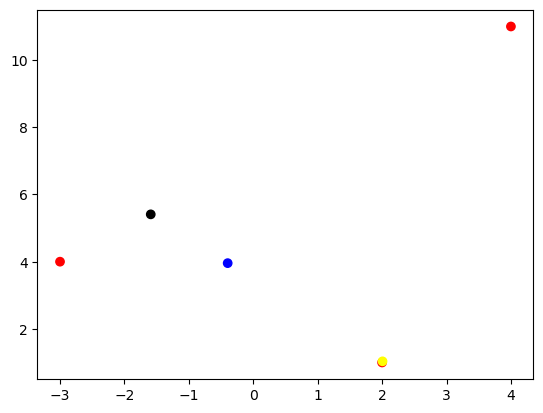

In [3]:
a=np.array([2,1])
b=np.array([4,11])
c=np.array([-3,4])
edge_weights= np.random.random(3)
# edge_weights= np.ones(3)/4


d,p0,p1=get_point_inside_triange(a,b,c,edge_weights)
print(f"weights {edge_weights} d {d}")
points_const= np.stack([a,b,c,d,p0,p1])
X,Y=list(toolz.sandbox.core.unzip(points_const))
X=list(X)
Y=list(Y)
plt.scatter(X,Y,color=['red','red','red','blue','yellow','black'])
plt.show()

[3.0, 1.0]


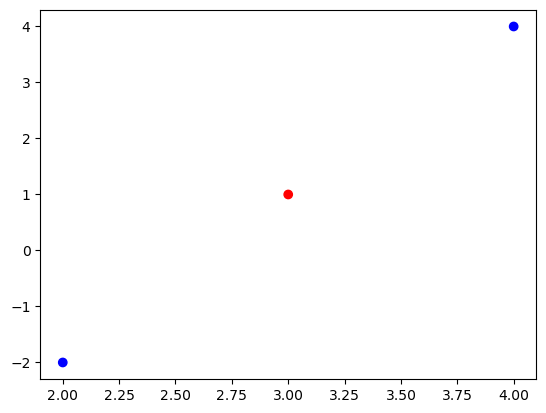

In [4]:
def get_point_on_a_line_b(vertex_0,vertex_1,weight):
    diff_x=vertex_1[0]-vertex_0[0]
    diff_y=vertex_1[1]-vertex_0[1]
    return [vertex_0[0]+(diff_x*weight),vertex_0[1]+(diff_y*weight)]

b=np.array([4,4])
a=np.array([2,-2])
# c=get_point_on_a_line_b(b,a,-0.3)
c=get_point_on_a_line_b(b,a,0.5)
print(c)
points_const= np.stack([b,a,c])
X,Y=list(toolz.sandbox.core.unzip(points_const))
X=list(X)
Y=list(Y)
plt.scatter(X,Y,color=['blue','blue','red'])
plt.show()

In [5]:
a=np.array([0,8,7,3])
a[1:-2]
a[0:-3]

array([0])

In [35]:
import einops
def get_triangles_data():
    """ 
    manually setting data about what triangles are present in each square 
    it is based on set of sv centers and control points - also comments are to the upper left square of the image in 
    /workspaces/jax_cpu_experiments_b/geometric_sv_idea/triangle_geometric_sv.jpg
    we will also use the id of nodes as in the image bottom right
    single triangle data will consist of 4 entries - first 3 will be verticies ids as in image and the last one the id of the sv that is owner of this node
        as in the alpha order 
    we also organize triangles in primary triangles what is very usefull for additional control points managament    
    """
    return jnp.array([
          [[0,8,7,3]#I
         ,[0,8,1,0]]#A

         ,[[0,2,1,0]#B
         ,[0,2,3,1]]#C

         ,[[0,4,3,1]#D
         ,[0,4,5,2]]#L

         ,[[0,6,5,2]#K
         ,[0,6,7,3]]]#J
        )


def get_modified_triangles_data(num_additional_points,primary_control_points_offset):
    """ 
    as we can add variable number of additional control points we need also to include them in the analysis
    """
    triangles_data= get_triangles_data()
    triangles_data= np.array(triangles_data)
    triangles_data_prim= triangles_data
    #num_additional_points tell how many additional points we will insert per primary triangle
    #and we have 4 primary triangles
    triangles_data= list(map( lambda i :np.arange(primary_control_points_offset+i*num_additional_points,primary_control_points_offset+i*num_additional_points+num_additional_points),range(4)))
    triangles_data= einops.repeat(np.stack(triangles_data), 'a b-> a c b',c=2)
    triangles_data_beg= einops.rearrange(triangles_data_prim[:,:,0], 'a b-> a b 1')
    # , triangles_data,triangles_data_prim[:,-2:-1]
    triangles_data= np.concatenate([triangles_data_beg, triangles_data,triangles_data_prim[:,:,-3:]],axis=-1 )
    # triangles_data= list(map( lambda i :np.insert(triangles_data[i],1,np.arange(primary_control_points_offset+i*num_additional_points,primary_control_points_offset+i*num_additional_points+num_additional_points),axis=1),range(4)))

    return  jnp.array(triangles_data)

num_additional_points=3
primary_control_points_offset=9
get_modified_triangles_data(num_additional_points,primary_control_points_offset)


Array([[[ 0,  9, 10, 11,  8,  7,  3],
        [ 0,  9, 10, 11,  8,  1,  0]],

       [[ 0, 12, 13, 14,  2,  1,  0],
        [ 0, 12, 13, 14,  2,  3,  1]],

       [[ 0, 15, 16, 17,  4,  3,  1],
        [ 0, 15, 16, 17,  4,  5,  2]],

       [[ 0, 18, 19, 20,  6,  5,  2],
        [ 0, 18, 19, 20,  6,  7,  3]]], dtype=int32)